# Import Libraries

In [1]:
from __future__ import print_function
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms

## Data Transformations

We first start with defining our data transformations. We need to think what our data is and how can we augment it to correct represent images which it might not see otherwise.


In [2]:

# Train Phase transformations
train_transforms = transforms.Compose([
                                       transforms.RandomRotation((-7.0, 7.0), fill=(1,)),
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.1307,), (0.3081,)) # The mean and std have to be sequences (e.g., tuples), therefore you should add a comma after the values.
                                       # Note the difference between (0.1307) and (0.1307,)
                                       ])

# Test Phase transformations
test_transforms = transforms.Compose([
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.1307,), (0.3081,))
                                       ])


# Dataset and Creating Train/Test Split

In [3]:
train = datasets.MNIST('./data', train=True, download=True, transform=train_transforms)
test = datasets.MNIST('./data', train=False, download=True, transform=test_transforms)

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 9.91M/9.91M [00:01<00:00, 5.09MB/s]


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 28.9k/28.9k [00:00<00:00, 134kB/s]


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 1.65M/1.65M [00:01<00:00, 1.27MB/s]


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 4.54k/4.54k [00:00<00:00, 4.32MB/s]

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



# Dataloader Arguments & Test/Train Dataloaders


In [4]:
SEED = 1

# CUDA?
cuda = torch.cuda.is_available()
print("CUDA Available?", cuda)

# For reproducibility
torch.manual_seed(SEED)

if cuda:
    torch.cuda.manual_seed(SEED)

# dataloader arguments - something you'll fetch these from cmdprmt
dataloader_args = dict(shuffle=True, batch_size=128, num_workers=4, pin_memory=True) if cuda else dict(shuffle=True, batch_size=64)

# train dataloader
train_loader = torch.utils.data.DataLoader(train, **dataloader_args)

# test dataloader
test_loader = torch.utils.data.DataLoader(test, **dataloader_args)

CUDA Available? True


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


# Data Statistics


torch.Size([128, 1, 28, 28])
torch.Size([128])


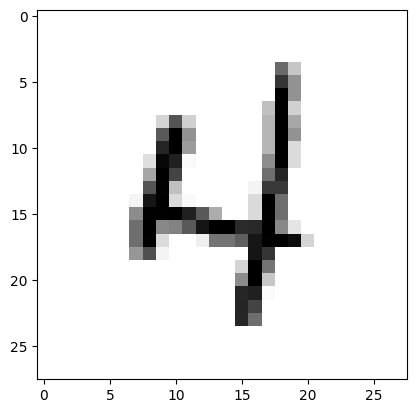

In [5]:
dataiter = iter(train_loader)
images, labels = next(dataiter)

print(images.shape)
print(labels.shape)

# Let's visualize some of the images
%matplotlib inline
import matplotlib.pyplot as plt

plt.imshow(images[0].numpy().squeeze(), cmap='gray_r')


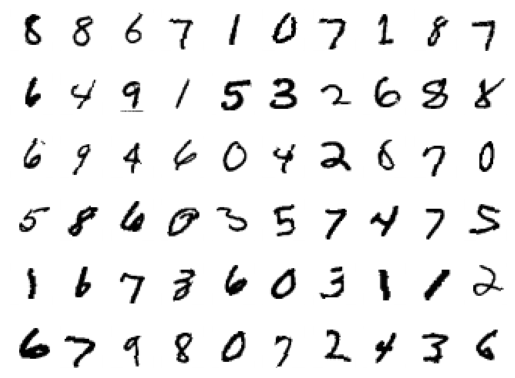

In [6]:
figure = plt.figure()
num_of_images = 60
for index in range(1, num_of_images + 1):
    plt.subplot(6, 10, index)
    plt.axis('off')
    plt.imshow(images[index].numpy().squeeze(), cmap='gray_r')

## Model



In [7]:
class MNISTNet(nn.Module):
    def __init__(self):
        super(MNISTNet, self).__init__()

        self.conv1 = nn.Conv2d(in_channels=1, out_channels=8, kernel_size=(3, 3), padding=0, bias=False)
        self.bnorm1 = nn.BatchNorm2d(8)
        # 28 -> 26 x 26 x 8 | RF - 3

        self.conv2 = nn.Conv2d(in_channels=8, out_channels=10, kernel_size=(3, 3), padding=0, bias=False)
        self.bnorm2 = nn.BatchNorm2d(10)
        # 26 -> 24 x 24 x 10 | RF - 5

        self.conv3 = nn.Conv2d(in_channels=10, out_channels=16, kernel_size=(3, 3), padding=0, bias=False)
        self.bnorm3 = nn.BatchNorm2d(16)
        # 24 -> 22 x 22 x 16 | RF - 7

        self.pool1 = nn.MaxPool2d(2, 2)
        # 22 -> 11 x 11 x 16 | RF - 8

        self.noconv1 = nn.Conv2d(in_channels=16, out_channels=10, kernel_size=(1, 1), padding=0, bias=False)
        # 11 -> 11 x 11 x 10 | RF - 8

        self.conv4 = nn.Conv2d(in_channels=10, out_channels=10, kernel_size=(3, 3), padding=0, bias=False)
        self.bnorm4 = nn.BatchNorm2d(10)
        # 11 -> 9 x 9 x 10 | RF - 12

        self.conv5 = nn.Conv2d(in_channels=10, out_channels=10, kernel_size=(3, 3), padding=0, bias=False)
        self.bnorm5 = nn.BatchNorm2d(10)
        # 9 -> 7 x 7 x 10 | RF - 16

        self.conv6 = nn.Conv2d(in_channels=10, out_channels=12, kernel_size=(3, 3), padding=0, bias=False)
        self.bnorm6 = nn.BatchNorm2d(12)
        # 7 -> 5 x 5 x 12 | RF - 20

        self.conv7 = nn.Conv2d(in_channels=12, out_channels=16, kernel_size=(3, 3), padding=0, bias=False)
        self.bnorm7 = nn.BatchNorm2d(16)
        # 5 -> 3 x 3 x 16 | RF - 24

        # OUTPUT BLOCK
        self.gap = nn.AvgPool2d(kernel_size=3)
        # 3 x 3 x 16 -> 1 x 1 x 16 | RF - 28

        self.conv8 = nn.Conv2d(in_channels=16, out_channels=10, kernel_size=(1, 1), padding=0, bias=False)

        self.dropout = nn.Dropout(0.1)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = self.bnorm1(x)

        x = F.relu(self.conv2(x))
        x = self.bnorm2(x)

        x = F.relu(self.conv3(x))
        x = self.bnorm3(x)

        x = self.dropout(x)
        x = self.pool1(x)

        x = self.noconv1(x)

        x = F.relu(self.conv4(x))
        x = self.bnorm4(x)

        x = F.relu(self.conv5(x))
        x = self.bnorm5(x)

        x = F.relu(self.conv6(x))
        x = self.bnorm6(x)

        x = F.relu(self.conv7(x))
        x = self.bnorm7(x)

        x = self.dropout(x)
        x = self.gap(x)
        x = self.conv8(x)
        x = x.view(-1, 10)
        return F.log_softmax(x, dim=-1)

## Model Params

In [8]:
!pip install torchsummary
from torchsummary import summary
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print(device)
model = MNISTNet().to(device)
summary(model, input_size=(1, 28, 28))

cuda
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 8, 26, 26]              72
       BatchNorm2d-2            [-1, 8, 26, 26]              16
            Conv2d-3           [-1, 10, 24, 24]             720
       BatchNorm2d-4           [-1, 10, 24, 24]              20
            Conv2d-5           [-1, 16, 22, 22]           1,440
       BatchNorm2d-6           [-1, 16, 22, 22]              32
           Dropout-7           [-1, 16, 22, 22]               0
         MaxPool2d-8           [-1, 16, 11, 11]               0
            Conv2d-9           [-1, 10, 11, 11]             160
           Conv2d-10             [-1, 10, 9, 9]             900
      BatchNorm2d-11             [-1, 10, 9, 9]              20
           Conv2d-12             [-1, 10, 7, 7]             900
      BatchNorm2d-13             [-1, 10, 7, 7]              20
           Conv2d-14             [

## Training and Testing

In [9]:
from tqdm import tqdm

train_losses = []
test_losses = []
train_acc = []
test_acc = []

def train(model, device, train_loader, optimizer, epoch):
  model.train()
  pbar = tqdm(train_loader)
  correct = 0
  processed = 0
  for batch_idx, (data, target) in enumerate(pbar):
    # get samples
    data, target = data.to(device), target.to(device)

    # Init
    optimizer.zero_grad()
    # In PyTorch, we need to set the gradients to zero before starting to do backpropragation because PyTorch accumulates the gradients on subsequent backward passes.
    # Because of this, when you start your training loop, ideally you should zero out the gradients so that you do the parameter update correctly.

    # Predict
    y_pred = model(data)

    # Calculate loss
    loss = F.nll_loss(y_pred, target)
    train_losses.append(loss)

    # Backpropagation
    loss.backward()
    optimizer.step()

    # Update pbar-tqdm

    pred = y_pred.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
    correct += pred.eq(target.view_as(pred)).sum().item()
    processed += len(data)

    pbar.set_description(desc= f'Loss={loss.item()} Batch_id={batch_idx} Accuracy={100*correct/processed:0.2f}')
    train_acc.append(100*correct/processed)

def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    test_losses.append(test_loss)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))

    test_acc.append(100. * correct / len(test_loader.dataset))

## Let's Train and test our model

In [10]:
model =  MNISTNet().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
EPOCHS = 15
for epoch in range(EPOCHS):
    print("EPOCH:", epoch+1)
    train(model, device, train_loader, optimizer, epoch)
    test(model, device, test_loader)

EPOCH: 1


Loss=0.061894357204437256 Batch_id=468 Accuracy=92.29: 100%|██████████| 469/469 [00:28<00:00, 16.37it/s]



Test set: Average loss: 0.0560, Accuracy: 9857/10000 (98.57%)

EPOCH: 2


Loss=0.06937693804502487 Batch_id=468 Accuracy=98.08: 100%|██████████| 469/469 [00:21<00:00, 22.22it/s]



Test set: Average loss: 0.0437, Accuracy: 9881/10000 (98.81%)

EPOCH: 3


Loss=0.019564559683203697 Batch_id=468 Accuracy=98.32: 100%|██████████| 469/469 [00:20<00:00, 22.51it/s]



Test set: Average loss: 0.0354, Accuracy: 9892/10000 (98.92%)

EPOCH: 4


Loss=0.0195819940418005 Batch_id=468 Accuracy=98.47: 100%|██████████| 469/469 [00:22<00:00, 20.87it/s]



Test set: Average loss: 0.0335, Accuracy: 9889/10000 (98.89%)

EPOCH: 5


Loss=0.0777834802865982 Batch_id=468 Accuracy=98.71: 100%|██████████| 469/469 [00:22<00:00, 21.23it/s]



Test set: Average loss: 0.0329, Accuracy: 9899/10000 (98.99%)

EPOCH: 6


Loss=0.0544172041118145 Batch_id=468 Accuracy=98.78: 100%|██████████| 469/469 [00:20<00:00, 22.41it/s]



Test set: Average loss: 0.0352, Accuracy: 9893/10000 (98.93%)

EPOCH: 7


Loss=0.011425520293414593 Batch_id=468 Accuracy=98.85: 100%|██████████| 469/469 [00:22<00:00, 21.02it/s]



Test set: Average loss: 0.0382, Accuracy: 9885/10000 (98.85%)

EPOCH: 8


Loss=0.015645353123545647 Batch_id=468 Accuracy=98.91: 100%|██████████| 469/469 [00:20<00:00, 22.38it/s]



Test set: Average loss: 0.0282, Accuracy: 9910/10000 (99.10%)

EPOCH: 9


Loss=0.0020468428265303373 Batch_id=468 Accuracy=98.99: 100%|██████████| 469/469 [00:21<00:00, 21.95it/s]



Test set: Average loss: 0.0341, Accuracy: 9891/10000 (98.91%)

EPOCH: 10


Loss=0.001724605797789991 Batch_id=468 Accuracy=98.94: 100%|██████████| 469/469 [00:22<00:00, 20.77it/s]



Test set: Average loss: 0.0263, Accuracy: 9915/10000 (99.15%)

EPOCH: 11


Loss=0.0041377306915819645 Batch_id=468 Accuracy=99.09: 100%|██████████| 469/469 [00:21<00:00, 22.11it/s]



Test set: Average loss: 0.0275, Accuracy: 9917/10000 (99.17%)

EPOCH: 12


Loss=0.003580502001568675 Batch_id=468 Accuracy=99.03: 100%|██████████| 469/469 [00:21<00:00, 22.21it/s]



Test set: Average loss: 0.0310, Accuracy: 9908/10000 (99.08%)

EPOCH: 13


Loss=0.015120335854589939 Batch_id=468 Accuracy=99.11: 100%|██████████| 469/469 [00:22<00:00, 20.98it/s]



Test set: Average loss: 0.0274, Accuracy: 9917/10000 (99.17%)

EPOCH: 14


Loss=0.009407085366547108 Batch_id=468 Accuracy=99.12: 100%|██████████| 469/469 [00:21<00:00, 22.28it/s]



Test set: Average loss: 0.0244, Accuracy: 9921/10000 (99.21%)

EPOCH: 15


Loss=0.06469260901212692 Batch_id=468 Accuracy=99.17: 100%|██████████| 469/469 [00:20<00:00, 22.40it/s]



Test set: Average loss: 0.0265, Accuracy: 9922/10000 (99.22%)



In [11]:
%matplotlib inline
import matplotlib.pyplot as plt

def plot_training_curve(train_losses, train_acc, test_losses, test_acc):
    t = [t_items.item() for t_items in train_losses]
    fig, axs = plt.subplots(2,2,figsize=(15,10))
    axs[0, 0].plot(t)
    axs[0, 0].set_title("Training Loss")
    axs[1, 0].plot(train_acc[4000:])
    axs[1, 0].set_title("Training Accuracy")
    axs[0, 1].plot(test_losses)
    axs[0, 1].set_title("Test Loss")
    axs[1, 1].plot(test_acc)
    axs[1, 1].set_title("Test Accuracy")

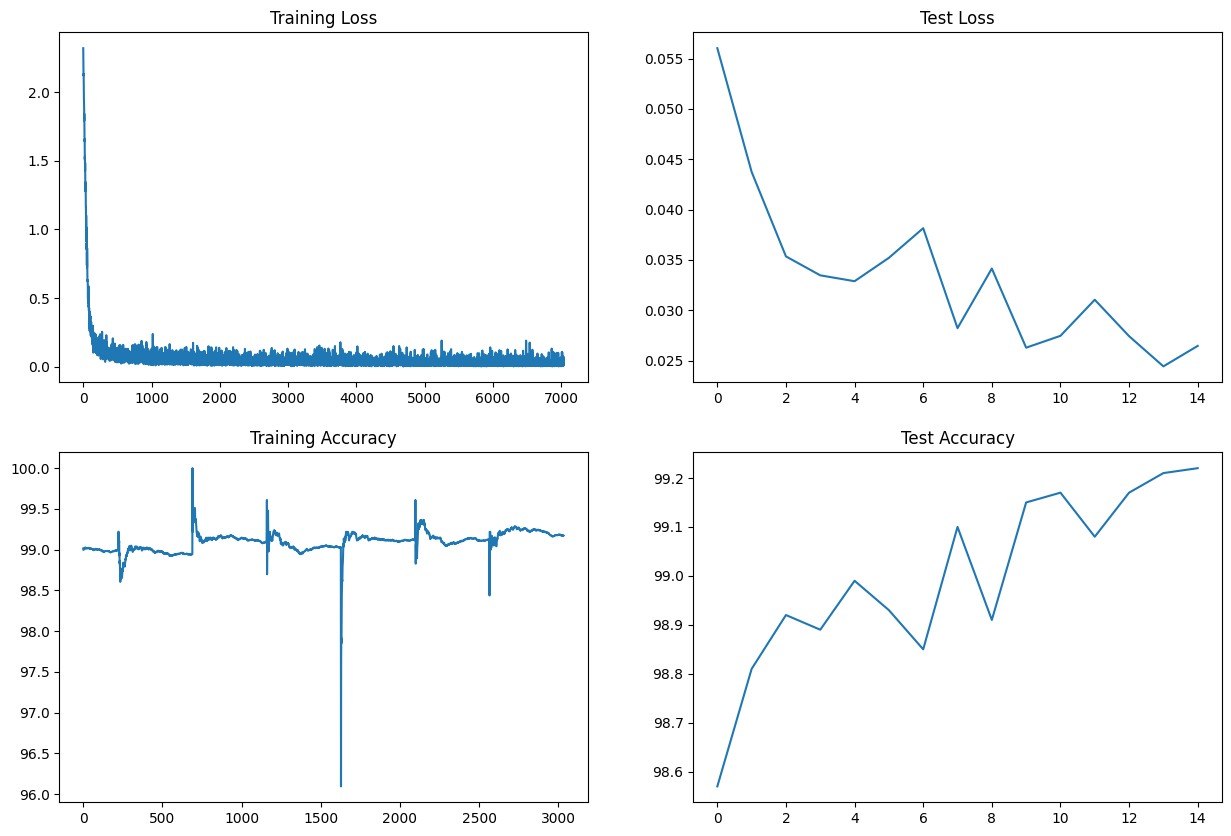

In [12]:
plot_training_curve(train_losses, train_acc, test_losses, test_acc)

## Target, Results and Analysis

### Target
- Change Architecture to have less than 8000 parameters
- Reduce the GAP Kernel size to 3 x 3.
- Add layer after GAP and add layers to back to increase accuracy.
- Add batch normalization and dropout to regualarize the network as we have increased the number of layers in the architecture.
- Achieving > 99.4 % accuracy in less than 15 epochs

  
### Result

Model Parameters: 7344  
Best Train Accuracy: 99.17  
Best Test Accuracy: 99.22
  
### Analysis
- The network has been added with many layers, and Batch Norm, but it could not achieve more than 99.22% accuracy in 15 epochs. So model is not converging quickly.
- Dropout value might be high for this network.
